In [5]:
import pandas as pd
import  matplotlib.pyplot as plt
from  datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Time:", current_time)

# Imports data from csv file
initial_df= pd.read_csv('../raw_data/raw_polling_data.csv', parse_dates=['startdate', 'enddate'], dayfirst=True)

# Removes spaces and ampersands in pollster names
initial_df['pollster'] = initial_df['pollster'].str.replace(' ', '').str.replace('&', '').str.replace('-', '')

# Creates unique index for each poll
df_uuid = initial_df.set_index(initial_df['enddate'].dt.strftime('%Y-%m-%d').apply(str).str.replace('-', '_') + '_' + initial_df['pollster'])

# Pivots table to create column for each party
df = df_uuid.pivot_table(values="votingintention", index=[df_uuid.index,\
                                                                        'startdate', 'enddate', 'pollster', 'samplesize', 'countrycode'], columns=['partycode'])
df.reset_index(level=['startdate', 'enddate', 'pollster', 'samplesize', 'countrycode'], inplace=True)
df.reset_index(drop=True, inplace=True)


Current Time: 2024-06-05 10:49:53


In [6]:
# Filters to after January 1, 2004
df = df[df['enddate'] > '2004-01-01']

In [7]:
# Removes pollsters with fewer than 10 polls
pollster_counts = df['pollster'].value_counts()
valid_pollsters = pollster_counts[pollster_counts >= 10].index
df = df[df['pollster'].isin(valid_pollsters)]

In [8]:
# Adds pollster rating, drawn from Election Data Vault
pollster_ratings = {
    'Populus': 'D+',
    'ICM': 'D+',
    'IpsosMORI': 'A-',
    'YouGov': 'A-',
    'SavantaComRes': 'B+',
    'BPIX': 'F',
    'AngusReid': 'F',
    'Harris': 'C-',
    'TNSBMRB': 'D',
    'Opinium': 'A-',
    'Survation': 'A-',
    'LordAshcroft': 'D-',
    'Panelbase': 'A-',
    'BMG': 'B',
    'ORB': 'D+',
    'Kantar': 'B+',
    'Deltapoll': 'D+',
    'NumberCruncherPolitics': 'D',
    'Focaldata': 'D+',
    'RedfieldWilton': 'D',
    'JLPartners': 'D',
    'FindOutNow': 'D',
    'Omnisis': 'D',
    'Techne': 'D',
    'PeoplePolling': 'D',
    'MoreinCommon': 'F'
}
# Adds rating column
df['pollster_rating'] = df['pollster'].map(pollster_ratings)

In [9]:
election_dates = [
    datetime.strptime('2005-05-05', "%Y-%m-%d"),
    datetime.strptime('2010-05-06', "%Y-%m-%d"),
    datetime.strptime('2015-05-07', "%Y-%m-%d"),
    datetime.strptime('2017-06-08', "%Y-%m-%d"),
    datetime.strptime('2019-12-12', "%Y-%m-%d"),
    datetime.strptime('2024-07-04', "%Y-%m-%d")
]

In [10]:
# Defines function to calculate time until next election
def find_next_election_date(start_date, election_dates):
    for election_date in election_dates:
        if start_date < election_date:
            return election_date
    return pd.NaT

In [11]:
# Creates next election date column
df['next_election_date'] = df['startdate'].apply(lambda x: find_next_election_date(x, election_dates))
df['days_until_next_election'] = (df['next_election_date'] - df['startdate']).dt.days

In [12]:
# Countrycode definitions
sco = ['SCO'] # defines Scotland
gb = ['GBR'] # defines Great Britain
wal = ['WAL'] # defines Wales
nir = ['NIR']   # defines Northern Ireland
ukm = ['UKM']  # defines \United Kingdom
enw = ['ENW'] # defines England and Wales

In [13]:
# Creates subsets of polls
gb_polls = df[df['countrycode'].isin(gb)] # 4622 polls
sco_polls = df[df['countrycode'].isin(sco)] # 213 polls
wal_polls = df[df['countrycode'].isin(wal)] #91 polls
ukm_polls = df[df['countrycode'].isin(ukm)] #428 polls

#Disregard:
nir_polls = df[df['countrycode'].isin(nir)] # Inclined to disregard, only 1 polls
enw_polls = df[df['countrycode'].isin(enw)] # Inclined to disregard, only 1 [poll ]

In [14]:
# Defines relevant parties for each country
gb_columns = ['startdate', 'enddate', 'pollster', 'samplesize', 'pollster_rating', 'next_election_date', 'days_until_next_election', 'BRX', 'CON', 'GRE', 'LAB', 'LIB', 'NAT', 'OTH', 'PLC', 'SNP', 'UKI']
sco_columns = ['startdate', 'enddate', 'pollster', 'samplesize', 'pollster_rating', 'next_election_date', 'days_until_next_election', 'BRX', 'CON', 'GRE', 'LAB', 'LIB', 'OTH', 'SNP', 'OTH', 'UKI']
ukm_columns = ['startdate', 'enddate', 'pollster', 'samplesize', 'pollster_rating', 'next_election_date', 'days_until_next_election', 'BRX', 'CON', 'GRE', 'LAB', 'LIB', 'NAT', 'PLC', 'SNP', 'UKI']
wal_columns = ['startdate', 'enddate', 'pollster', 'samplesize', 'pollster_rating', 'next_election_date', 'days_until_next_election', 'BRX', 'CON', 'GRE', 'LAB', 'LIB', 'OTH', 'PLC', 'UKI']

In [15]:
# Filtered dataframe for GB with GB parties
gb_df = gb_polls[gb_columns]
# Filtered dataframe for Scotland with relevant parties
scotland_df = sco_polls[sco_columns]
# Filtered dataframe for Wales with relevant parties
wales_df = wal_polls[wal_columns]
# Filtered dataframe for UK with UK parties
uk_df = ukm_polls[ukm_columns]

In [16]:
gb_df['election_year'] = gb_df['next_election_date'].dt.year

/tmp/ipykernel_6998/900693759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gb_df['election_year'] = gb_df['next_election_date'].dt.year


In [17]:
gb_df.to_csv('../processed_data/gb_polls.csv', index=False)

In [591]:
results_df = pd.read_csv('../raw_data/election_results_dataframe.csv')

In [603]:
gb_polls_actuals = gb_df.merge(results_df, on='election_year', how='left')

In [604]:
# Defines parties for each country
sco_parties = ['BRX', 'CON', 'GRE', 'LAB', 'LIB', 'OTH', 'SNP', 'UKI']
gb_parties= ['BRX', 'CON', 'GRE', 'LAB', 'LIB', 'NAT', 'OTH', 'PLC', 'SNP', 'UKI']
ukm_parties = ['BRX', 'CON', 'GRE', 'LAB', 'LIB', 'NAT', 'PLC', 'SNP', 'UKI']
wal_parties = ['BRX', 'CON', 'GRE', 'LAB', 'LIB', 'OTH', 'PLC', 'UKI']

In [581]:
gb_df.columns

Index(['enddate', 'pollster', 'samplesize', 'pollster_rating',
       'next_election_date', 'days_until_next_election', 'BRX', 'CON', 'GRE',
       'LAB', 'LIB', 'NAT', 'OTH', 'PLC', 'SNP', 'UKI'],
      dtype='object', name='partycode')

In [ ]:
# # Exports to CSVs
# scotland_df.to_csv('../raw_data/scotland_polls.csv')
# gb_df.to_csv('../raw_data/gb_polls.csv')
# wal_df.to_csv('../raw_data/wales_polls.csv')
# ukm_df.to_csv('../raw_data/uk_polls.csv')

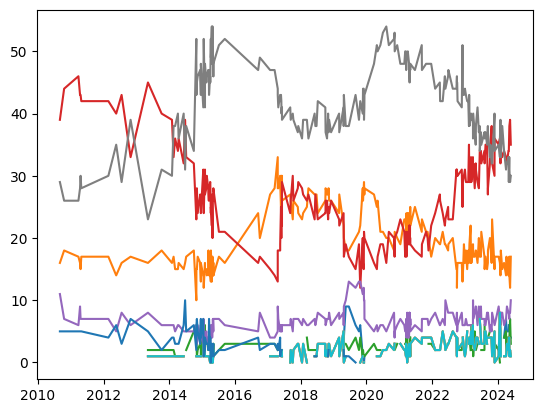

In [530]:
# Plots Scotland
plt.plot(scotland_df['enddate'], scotland_df[sco_parties])

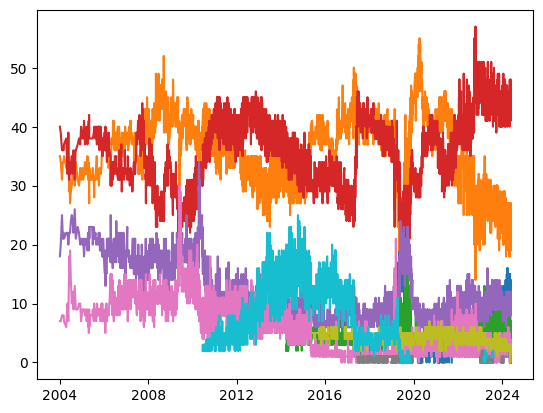

In [531]:
# Plots GB
plt.plot(gb_df['enddate'], gb_df[gb_parties])

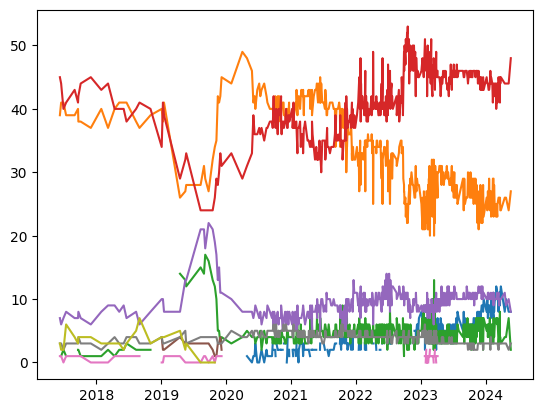

In [532]:
# Plots UKM
plt.plot(ukm_df['enddate'], ukm_df[ukm_parties])

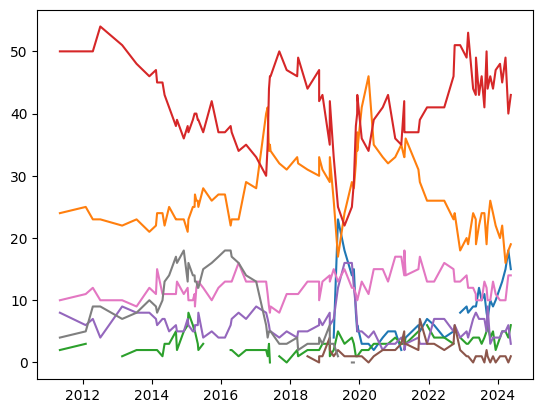

In [533]:
# Plots Wales
plt.plot(wal_df['enddate'], wal_df[wal_parties])

In [534]:
# Last ninety days for GB
last_90_days_df_gb = gb_df[gb_df['enddate'] >= gb_df['enddate'].max() - pd.Timedelta(days=90)]
# Last thirty days for GB
last_30_days_df_gb = gb_df[gb_df['enddate'] >= gb_df['enddate'].max() - pd.Timedelta(days=30)]

average_polling_last_90_days_gb = last_90_days_df_gb.mean(numeric_only=True)
average_polling_last_30_days_gb = last_30_days_df_gb.mean(numeric_only=True)

print(average_polling_last_90_days_gb)
print(average_polling_last_30_days_gb)

partycode
samplesize                  2169.375000
days_until_next_election      86.026786
BRX                           11.741071
CON                           23.428571
GRE                            5.892857
LAB                           43.910714
LIB                            9.642857
NAT                                 NaN
OTH                            2.355140
PLC                            0.892857
SNP                            2.747664
UKI                                 NaN
dtype: float64
partycode
samplesize                  2011.214286
days_until_next_election      55.595238
BRX                           11.476190
CON                           23.166667
GRE                            6.000000
LAB                           44.333333
LIB                            9.595238
NAT                                 NaN
OTH                            2.214286
PLC                            0.789474
SNP                            2.619048
UKI                                 NaN
dtype

In [535]:
# Last ninety days for Scotland
last_90_days_df_scotland = scotland_df[scotland_df['enddate'] >=scotland_df['enddate'].max() - pd.Timedelta(days=90)]
# Last thirty days
last_30_days_df_scotland = scotland_df[scotland_df['enddate'] >= scotland_df['enddate'].max() - pd.Timedelta(days=30)]

average_polling_last_90_days_scotland = last_90_days_df_scotland.mean(numeric_only=True)
average_polling_last_30_days_scotland = last_30_days_df_scotland.mean(numeric_only=True)

print(average_polling_last_90_days_scotland)
print(average_polling_last_30_days_scotland)

partycode
samplesize                  1040.400000
days_until_next_election      74.000000
BRX                            4.888889
CON                           15.300000
GRE                            4.111111
LAB                           34.900000
LIB                            7.900000
OTH                            2.100000
SNP                           31.400000
OTH                            2.100000
UKI                                 NaN
dtype: float64
partycode
samplesize                  1036.333333
days_until_next_election      58.000000
BRX                            4.600000
CON                           15.000000
GRE                            4.400000
LAB                           36.166667
LIB                            8.166667
OTH                            2.333333
SNP                           30.833333
OTH                            2.333333
UKI                                 NaN
dtype: float64
